In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divinzz","key":"32800cff3be960ce5163d24f1d88acc5"}'}

In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:09<00:00, 42.4MB/s]
100% 1.04G/1.04G [00:09<00:00, 112MB/s] 


In [6]:
!unzip -o flickr8k.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [7]:
!ls /content/flickr8k


captions.txt  Images


In [8]:
import numpy as np
import pandas as pd
import os
image_path = ('/content/flickr8k/Images')
data = pd.read_csv('/content/flickr8k/captions.txt')
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [9]:
from matplotlib import pyplot as plt
from textwrap import wrap
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.    # 0,1

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

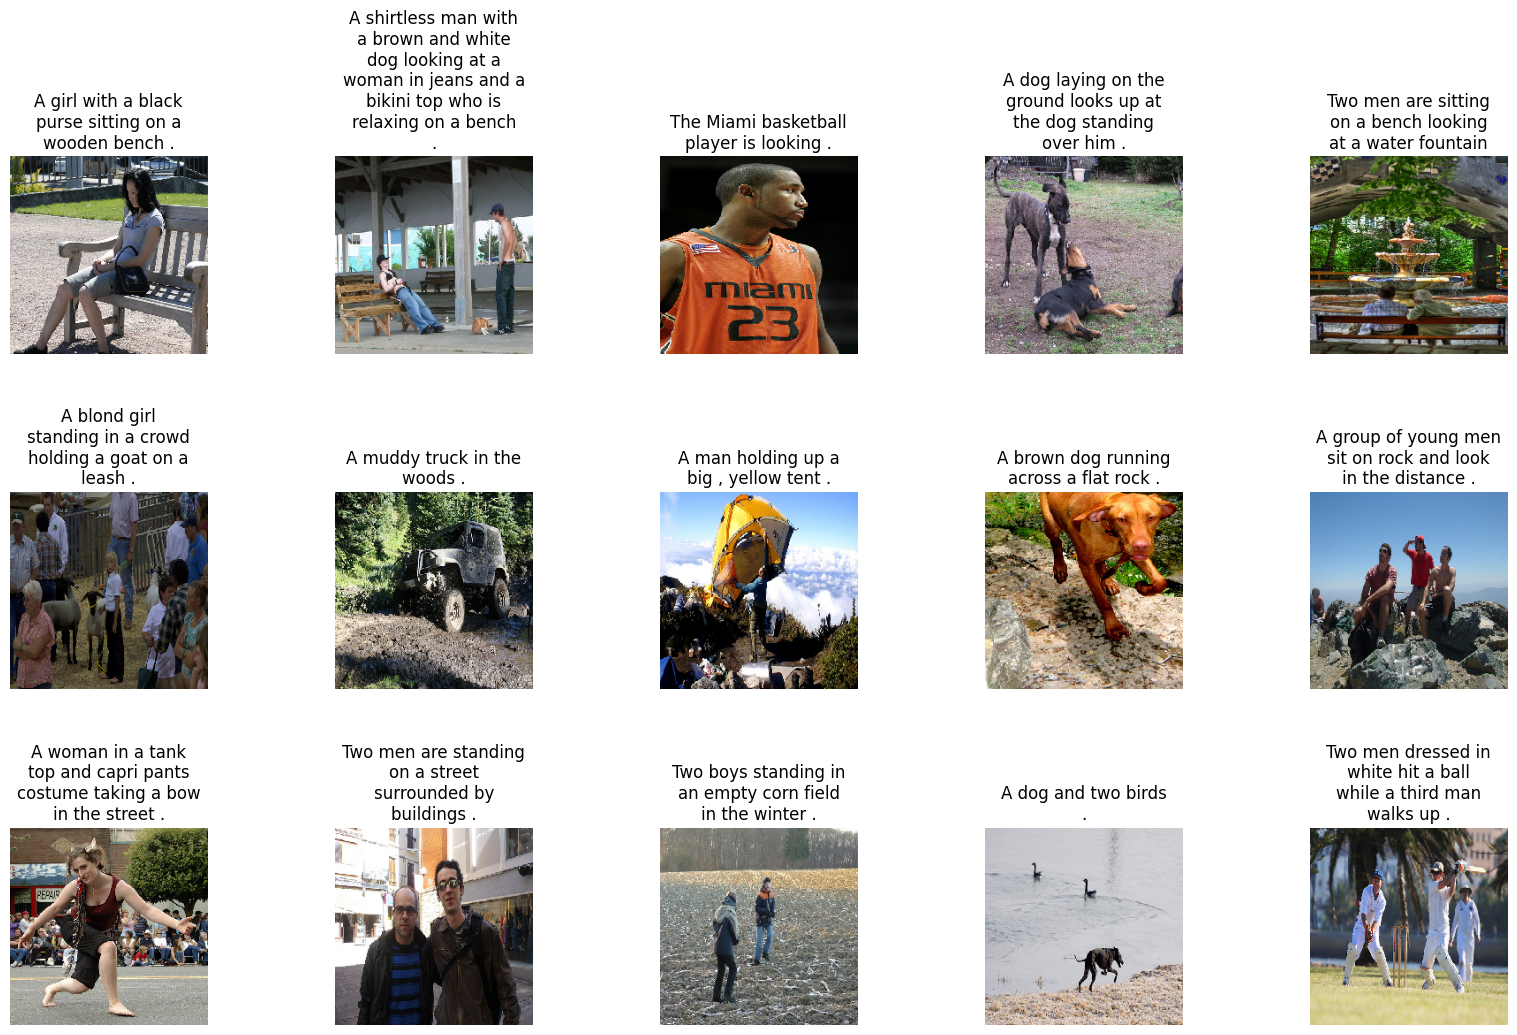

In [10]:
display_images(data.sample(15))

In [11]:
def text_preprocessing(data):
  data['caption'] = data['caption'].apply(lambda x: x.lower())
  data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
  data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
  data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
  data['caption'] = "startseq "+data['caption']+" endseq"

  return data

data = text_preprocessing(data)

caption = data['caption'].tolist()

caption[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

__Tokenization and Encoded Representation__

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(caption)

# tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

max_length = max([len(caption.split()) for caption in caption])
print(max_length)

images = data['image'].unique().tolist()
nimages = len(images)
print(nimages)

split_index = round(0.85*nimages)
train_images = images[ :split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([caption[1]])[0]



8485
34
8091


[1, 18, 315, 63, 195, 116, 2]

**Image** **feature** **Extraction**

In [13]:
import numpy as np
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

model = DenseNet201()

fe = Model(inputs = model.input, outputs=model.layers[-2].output)           #feature extractor

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
  img = load_img(os.path.join(image_path,image), target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/255.
  img = np.expand_dims(img, axis=0)
  feature = fe.predict(img, verbose=0)

  features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [14:14<00:00,  9.47it/s]


Modelling

In [14]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences

class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col                                                          # Initialization
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:                                                            # Shuffling the Data
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size           # 8000 samples and the batch size is 64  8000 // 64 = 125 batches per epoch.

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [15]:
train_generator[0]

((array([[7.8687939e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523460e-01,
          2.2903715e-01, 6.9639736e-01],
         [7.8687939e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523460e-01,
          2.2903715e-01, 6.9639736e-01],
         [7.8687939e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523460e-01,
          2.2903715e-01, 6.9639736e-01],
         ...,
         [1.9476045e-04, 7.0213026e-04, 1.4947482e-03, ..., 2.7233632e-02,
          5.5759561e-01, 3.8916555e-01],
         [1.9476045e-04, 7.0213026e-04, 1.4947482e-03, ..., 2.7233632e-02,
          5.5759561e-01, 3.8916555e-01],
         [1.9476045e-04, 7.0213026e-04, 1.4947482e-03, ..., 2.7233632e-02,
          5.5759561e-01, 3.8916555e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

In [16]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))


img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1,256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

history = caption_model.fit( train_generator, epochs=50, validation_data=validation_generator,
                            callbacks=[checkpoint,earlystopping,learning_rate_reduction])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 5.6402
Epoch 1: val_loss improved from inf to 4.17741, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 338s 611ms/step - loss: 5.6390 - val_loss: 4.1774 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 4.1945
Epoch 2: val_loss improved from 4.17741 to 3.87961, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 133s 161ms/step - loss: 4.1944 - val_loss: 3.8796 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.9128
Epoch 3: val_loss improved from 3.87961 to 3.74639, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 89s 165ms/step - loss: 3.9128 - val_loss: 3.7464 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 3.7304
Epoch 4: val_loss improved from 3.74639 to 3.68232, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 139s 160ms/step - loss: 3.7304 - val_loss: 3.6823 - learning_rate: 0.0010
Epoch 5/

In [17]:
history.history

{'loss': [5.010109901428223,
  4.131220817565918,
  3.8839797973632812,
  3.7315003871917725,
  3.6211438179016113,
  3.53351092338562,
  3.463444948196411,
  3.3984134197235107,
  3.3493523597717285,
  3.302126884460449,
  3.2578978538513184,
  3.2189559936523438,
  3.116744041442871,
  3.09063720703125],
 'val_loss': [4.177406311035156,
  3.8796093463897705,
  3.7463862895965576,
  3.6823172569274902,
  3.6449134349823,
  3.6379647254943848,
  3.625697612762451,
  3.621370315551758,
  3.6097259521484375,
  3.6420722007751465,
  3.651459217071533,
  3.6681277751922607,
  3.6780922412872314,
  3.68021559715271],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.00020000000949949026,
  0.00020000000949949026]}

**Learning Curve**

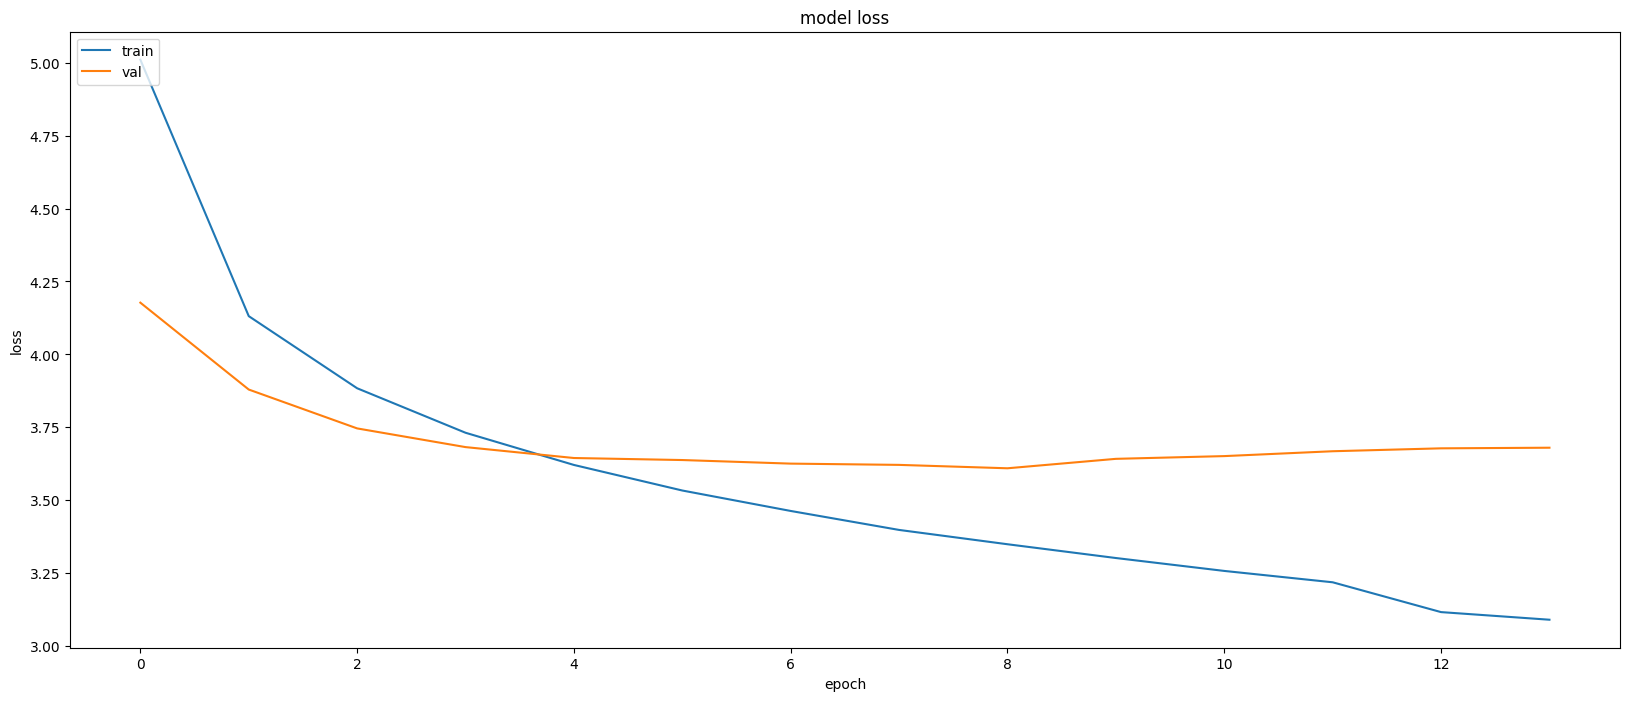

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Model** **Save**

In [29]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

**Caption** **Generation**

In [30]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle


model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

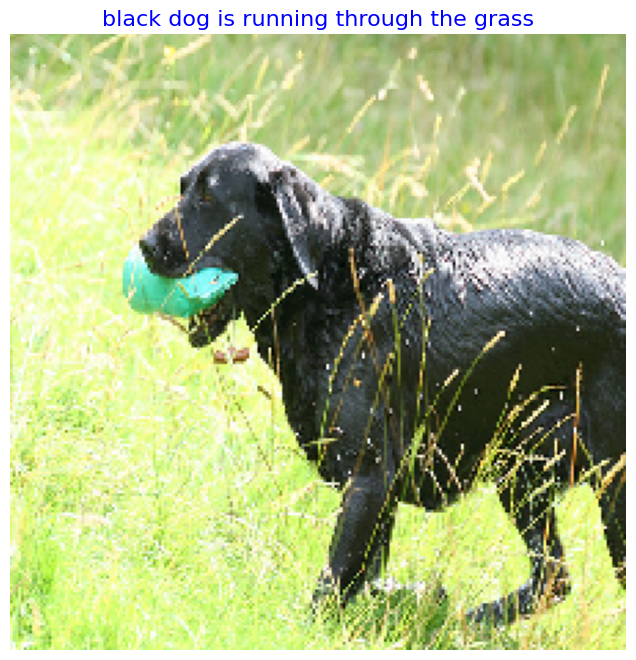

In [31]:
image_path = "/content/flickr8k/Images/1026685415_0431cbf574.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

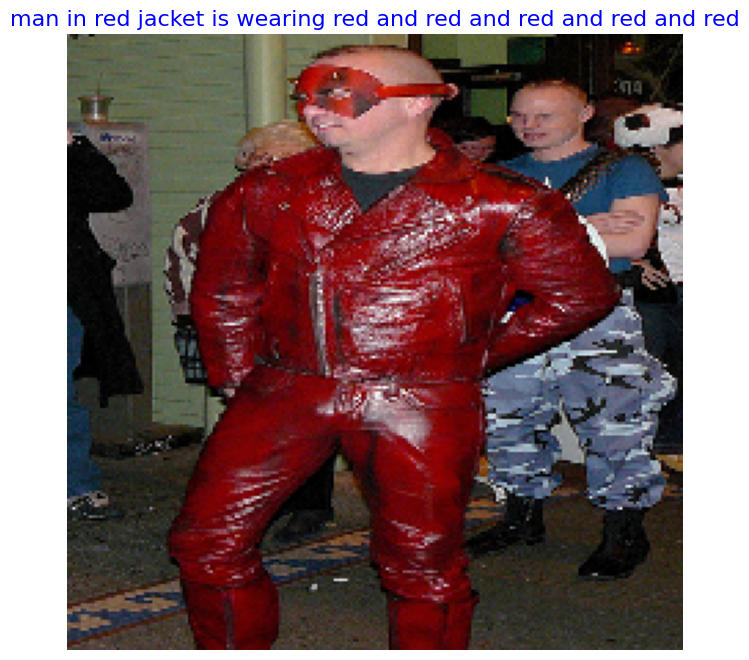

In [33]:
image_path = "/content/flickr8k/Images/1835511273_790eaae6e6.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

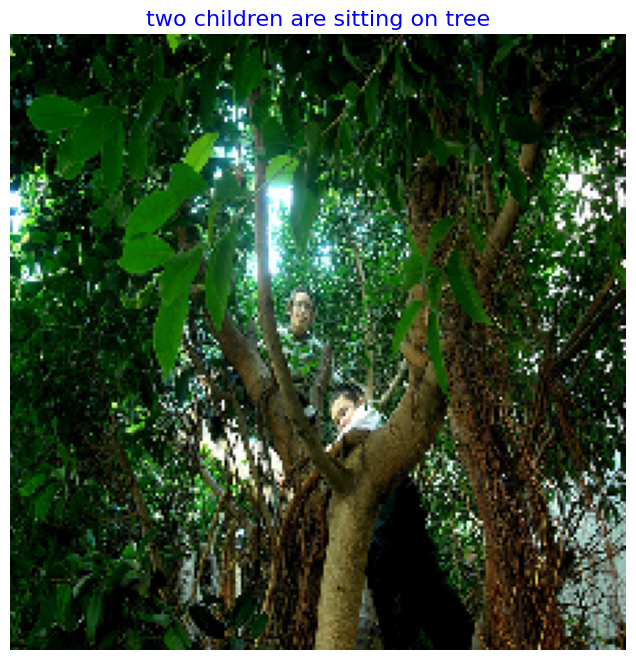

In [39]:
image_path = "/content/flickr8k/Images/1808504612_3508f3c9bb.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)